## Authorship Attribution and the Federalist Papers

This notebook explores the use of machine learning techniques to study the authorship of the Disputed and Co-authored Federalist Papers. We replicate and extend the work of Jockers and Witten (2010), who analyzed the stylistic patterns of Hamilton, Madison, and Jay using word frequencies. 

Using 1-gram and 2-gram lexical features derived from Lexos, we apply clustering and classification methods to explore patterns in known authors' writings and generate predictions for disputed texts.


## Loading and Cleaning the 1-gram Dataset

We begin by loading the 1-gram data, which contains proportional word frequencies for each of the 85 Federalist Papers. We remove non-paper rows such as "Total" and "Average", and filter out low-variance features (tokens with little to no variation across documents).


In [4]:
import pandas as pd

# Load 1-gram data
df_1gram = pd.read_csv('lexos_1gram_inALL_prop.csv', index_col=0)

# Preview the data
print("Shape:", df_1gram.shape)
df_1gram.head()


Shape: (87, 8726)


,the,of,to,and,in,a,be,that,it,is,...,extremities,extremes,extremely,extravagancies,extravagance,extraneous,extracts,extra,extortion,zealous
Total,7.9135,5.2608,3.1772,2.2978,1.9614,1.7622,1.7418,1.2402,1.1308,0.9257,...,0.0006,0.0034,0.0029,0.0005,0.0014,0.0008,0.0007,0.001,0.0002,0.0035
Average,0.0931,0.0619,0.0374,0.0270,0.0231,0.0207,0.0205,0.0146,0.0133,0.0109,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000
FED_18_C,0.1136,0.0639,0.0256,0.0374,0.0194,0.0175,0.0028,0.0099,0.0123,0.0047,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000
FED_19_C,0.1015,0.0610,0.0288,0.0400,0.0200,0.0132,0.0068,0.0063,0.0093,0.0078,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000
FED_20_C,0.0901,0.0533,0.0276,0.0355,0.0257,0.0184,0.0046,0.0059,0.0079,0.0099,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000


In [5]:
# Remove totals/averages if present
df_1gram = df_1gram[~df_1gram.index.str.contains("Total|Average", case=False)]


## Exploratory Data Check: Missing Values and Low-Variance Features

Before building models, we perform an initial quality check on the 1-gram dataset.  
- We verify that there are no missing values in the dataset.  
- We compute basic statistics to understand the distribution of word proportions.  
- We also identify tokens with very low standard deviation, as these offer little to no discriminative power and may be removed during feature selection.


In [7]:
# Check for nulls
df_1gram.isnull().sum().sum()

# Basic stats
df_1gram.describe()

# Check if any tokens are constant or nearly constant
df_1gram.std().sort_values().head(10)


specify            0.000022
confiscate         0.000022
summoner           0.000022
summoned           0.000022
assented           0.000022
sufferings         0.000022
host               0.000022
untouched          0.000022
conceding          0.000022
authoritatively    0.000022
dtype: float64

### Identifying Low-Variance Tokens

The output above shows a sample of tokens with extremely low standard deviation across all papers. These include rare words such as *"specify"*, *"summoned"*, and *"assented"*, each having a standard deviation of just 0.000022.

Such low-variance tokens are essentially constant and do not help distinguish between authors. Therefore, we remove them during preprocessing to improve model focus and reduce dimensionality.


In [9]:
df_1gram_cleaned = df_1gram[~df_1gram.index.str.contains("Total|Average", case=False)]
print("Cleaned shape:", df_1gram_cleaned.shape)


Cleaned shape: (85, 8726)


### Feature Selection: Removing Near-Constant Columns

To refine our dataset, we filter out columns (tokens) with a standard deviation lower than 0.00005. These tokens contribute minimal variation across documents and are unlikely to improve model performance.  

This filtering step significantly reduces the dimensionality of our data while preserving meaningful stylistic features.  
The resulting shape of the dataset confirms how many features (columns) remain after this process.


In [11]:
stds = df_1gram_cleaned.std()

### Visualizing Token Variability (Before Filtering)

Before filtering low-variance tokens, we plotted the distribution of standard deviations across all 1-gram word features...


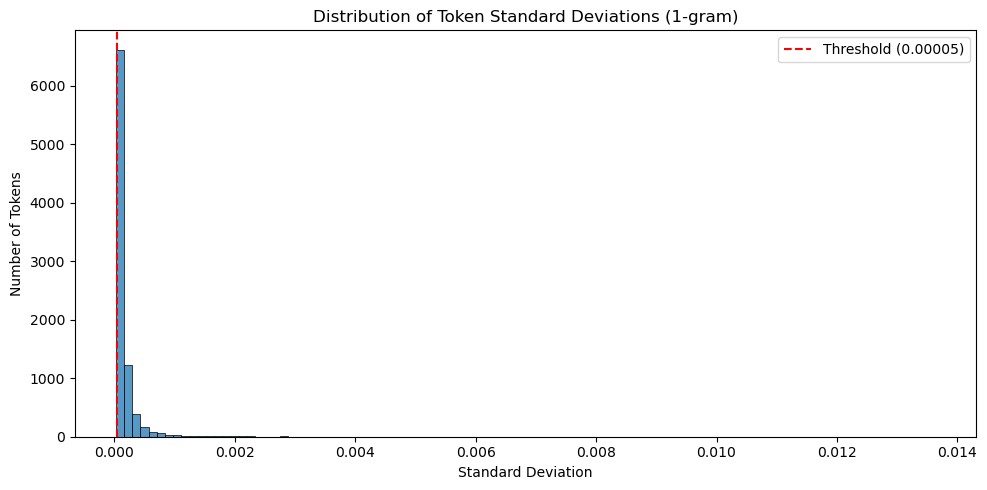

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(stds, bins=100, kde=False)
plt.axvline(0.00005, color='red', linestyle='--', label='Threshold (0.00005)')
plt.title("Distribution of Token Standard Deviations (1-gram)")
plt.xlabel("Standard Deviation")
plt.ylabel("Number of Tokens")
plt.legend()
plt.tight_layout()
plt.show()


### Visualizing Token Variability Before Filtering

Before filtering tokens based on low variance, we visualized the distribution of standard deviations across all 1-gram tokens.

As shown in the histogram, the vast majority of tokens have extremely low variability across documents clustering close to zero. These tokens are either rare or uniformly distributed and thus offer limited value in distinguishing writing styles.

We set a threshold at **0.00005** (red dashed line) to remove these near-constant features. This step reduces dimensionality while preserving tokens that are more stylistically meaningful.


In [15]:
df_1gram_filtered = df_1gram_cleaned.loc[:, stds > 0.00005]
print("Filtered shape:", df_1gram_filtered.shape)


Filtered shape: (85, 7117)


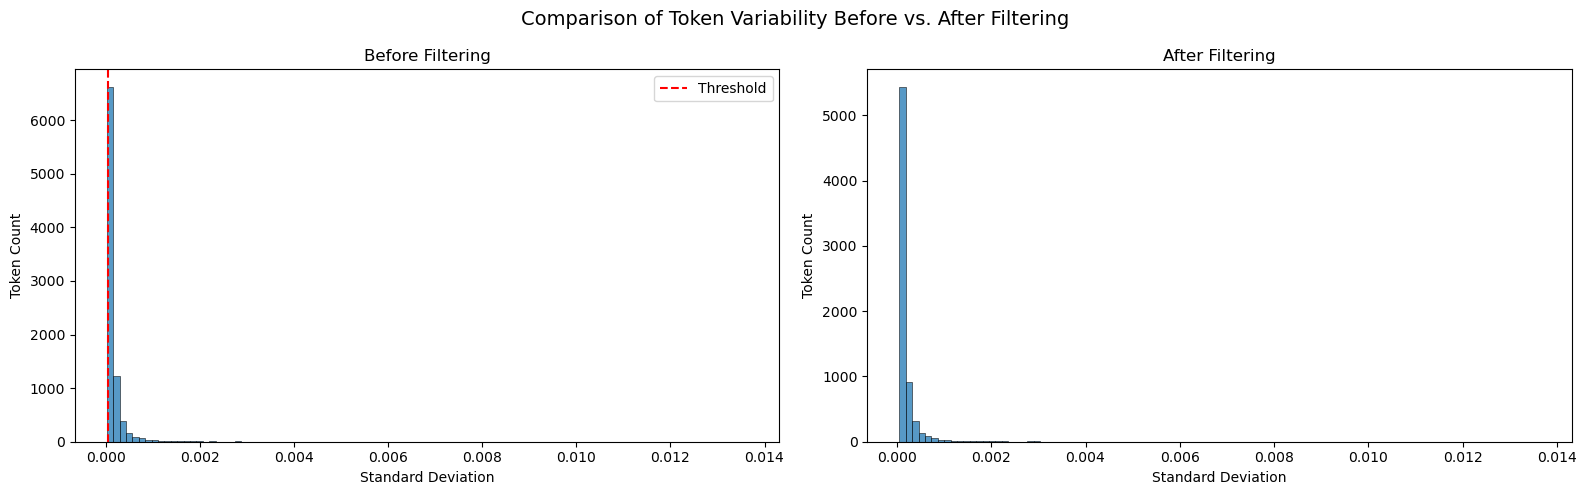

In [16]:
# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot BEFORE filtering
sns.histplot(stds, bins=100, ax=axs[0])
axs[0].axvline(0.00005, color='red', linestyle='--', label='Threshold')
axs[0].set_title("Before Filtering")
axs[0].set_xlabel("Standard Deviation")
axs[0].set_ylabel("Token Count")
axs[0].legend()

# Plot AFTER filtering
filtered_stds = df_1gram_filtered.std()
sns.histplot(filtered_stds, bins=100, ax=axs[1])
axs[1].set_title("After Filtering")
axs[1].set_xlabel("Standard Deviation")
axs[1].set_ylabel("Token Count")

plt.suptitle("Comparison of Token Variability Before vs. After Filtering", fontsize=14)
plt.tight_layout()
plt.show()


### Token Variability Before vs. After Filtering

The side-by-side histograms above show the distribution of standard deviations across all 1-gram tokens:

- **Before filtering (left)**: The vast majority of tokens have near-zero variance. These words either appear in almost every paper with the same frequency, or barely appear at all. As a result, they offer little value in distinguishing between authors' styles.

- **After filtering (right)**: We removed all tokens with a standard deviation less than **0.00005**. This leaves behind only the more informative, variable tokens. These retained words are more likely to reflect stylistic differences between authors and improve classification performance.

By removing low-variance features, we:
- Reduce dimensionality
- Improve model focus
- Prevent noise from dominating learning

This step ensures the models learn from **meaningful linguistic signals** rather than rare or flat features.


### Metadata Extraction: Paper ID, Author, and Type

We enrich our dataset by parsing metadata from the row names. Each Federalist Paper is labeled with a unique identifier that includes:
- The paper number (e.g., 18, 49)
- A code for the author (`H`, `M`, `J`, `D`, or `C`)

Using this, we extract:
- `paper_id`: the numeric ID of the paper
- `author`: the full name of the known or disputed author
- `paper_type`: whether the paper is *Known*, *Disputed*, or *Co-authored*


In [19]:
# Helper to extract metadata
def extract_meta(row_name):
    paper_id = row_name.split('_')[1]
    author_code = row_name.split('_')[2]

    # Map code to actual name
    author_map = {'H': 'Hamilton', 'M': 'Madison', 'J': 'Jay', 
                  'D': 'Disputed', 'C': 'Co-authored'}
    return pd.Series({
        'paper_id': int(paper_id),
        'author': author_map.get(author_code, 'Unknown'),
        'paper_type': 'Known' if author_code in ['H', 'M', 'J'] else ('Disputed' if author_code == 'D' else 'Co-authored')
    })

# Apply to your index
meta_df = df_1gram_filtered.index.to_series().apply(extract_meta)
df_1gram_final = df_1gram_filtered.copy()
df_1gram_final[['paper_id', 'author', 'paper_type']] = meta_df.values

df_1gram_final.head()


,the,of,to,and,in,a,be,that,it,is,...,extremes,extremely,extravagancies,extravagance,extraneous,extracts,extra,zealous,paper_id,paper_type
FED_18_C,0.1136,0.0639,0.0256,0.0374,0.0194,0.0175,0.0028,0.0099,0.0123,0.0047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,Co-authored
FED_19_C,0.1015,0.0610,0.0288,0.0400,0.0200,0.0132,0.0068,0.0063,0.0093,0.0078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,Co-authored
FED_20_C,0.0901,0.0533,0.0276,0.0355,0.0257,0.0184,0.0046,0.0059,0.0079,0.0099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,Co-authored
FED_49_D,0.1077,0.0611,0.0351,0.0254,0.0206,0.0200,0.0284,0.0127,0.0157,0.0109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,Disputed
FED_50_D,0.0911,0.0541,0.0252,0.0298,0.0252,0.0126,0.0280,0.0108,0.0144,0.0054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,Disputed


### Cleaned and Enriched Dataset Preview

The final processed 1-gram dataset now includes 85 Federalist Papers (after removing totals/averages) and 7,118 selected tokens (after removing low-variance features).

We’ve also appended three new columns:
- `paper_id`: numerical ID of the paper
- `author`: the known or assumed author (Hamilton, Madison, Jay, etc.)
- `paper_type`: classified as *Known*, *Disputed*, or *Co-authored*

This structured DataFrame is now ready for clustering and classification tasks.


## Clustering with PCA and KMeans (1-gram)

To visualize stylistic similarities among the Federalist Papers, we first reduce the high-dimensional 1-gram feature space to two principal components using **Principal Component Analysis (PCA)**.

We then apply **KMeans clustering (k=3)** to group the papers into stylistically similar clusters. The resulting scatter plot displays:
- Papers positioned by their first two PCA components
- Color-coded authors
- Paper types (Known, Disputed, Co-authored) distinguished by marker style

This unsupervised clustering helps reveal whether Disputed and Co-authored papers stylistically align with any known author group.


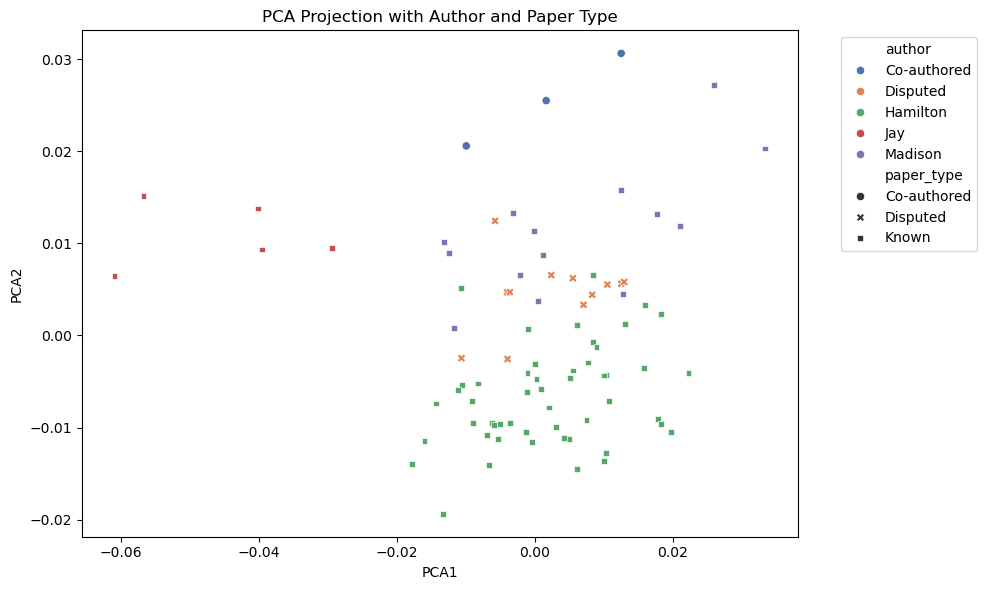

In [22]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Remove metadata before PCA
features = df_1gram_final.drop(columns=['paper_id', 'author', 'paper_type'])

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Add results back
df_1gram_final['cluster'] = clusters
df_1gram_final['PCA1'] = X_pca[:, 0]
df_1gram_final['PCA2'] = X_pca[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_1gram_final, x='PCA1', y='PCA2', hue='author', style='paper_type', palette='deep')
plt.title('PCA Projection with Author and Paper Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/d4/jv9n1vcx3fjdw6fyxj3hj9tc0000gn/T/ipykernel_96530/1232394992.py:24: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(subset['PCA1'], subset['PCA2'],


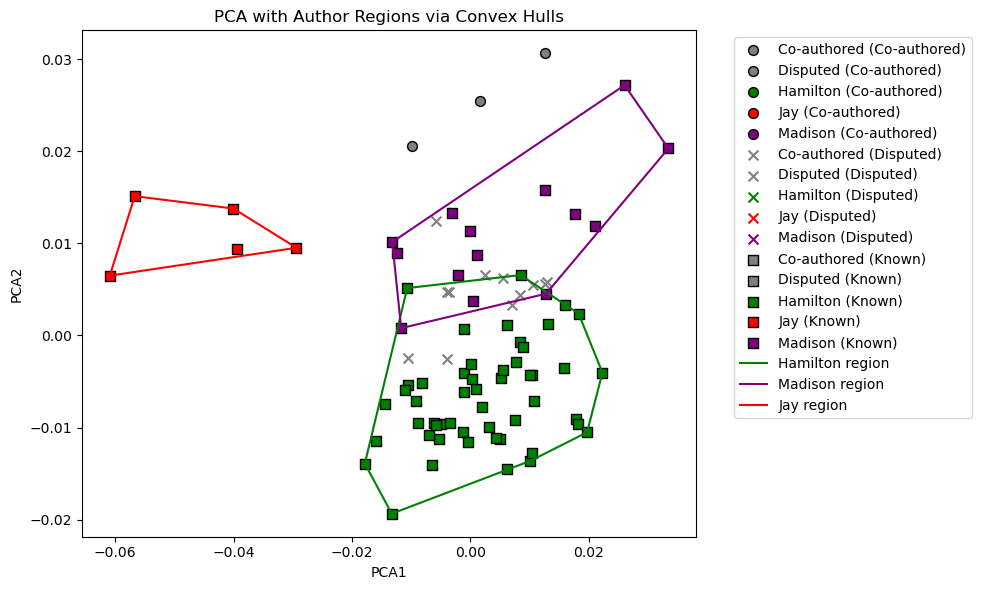

In [23]:
from scipy.spatial import ConvexHull

# Helper function to draw convex hull
def draw_hull(ax, points, color, label=None):
    if len(points) < 3:
        return
    hull = ConvexHull(points)
    for i, simplex in enumerate(hull.simplices):
        ax.plot(points[simplex, 0], points[simplex, 1], color=color,
                label=label if i == 0 else None)  # Only label the first segment

# Set up plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot each author group
palette = {'Hamilton': 'green', 'Madison': 'purple', 'Jay': 'red'}
markers = {'Known': 's', 'Disputed': 'x', 'Co-authored': 'o'}

# Plot individual points
for paper_type in df_1gram_final['paper_type'].unique():
    for author in df_1gram_final['author'].unique():
        subset = df_1gram_final[(df_1gram_final['author'] == author) & (df_1gram_final['paper_type'] == paper_type)]
        ax.scatter(subset['PCA1'], subset['PCA2'],
                   label=f"{author} ({paper_type})",
                   c=palette.get(author, 'gray'),
                   marker=markers[paper_type], s=50, edgecolors='k')

# Draw convex hulls around known-author groups only
for author in ['Hamilton', 'Madison', 'Jay']:
    known_pts = df_1gram_final[(df_1gram_final['author'] == author) & (df_1gram_final['paper_type'] == 'Known')]
    points = known_pts[['PCA1', 'PCA2']].values
    draw_hull(ax, points, palette[author], label=f"{author} region")

plt.title("PCA with Author Regions via Convex Hulls")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Author Regions via Convex Hulls

To further visualize stylistic differences, we draw **convex hulls** around the known papers of each author in the PCA space. These hulls represent the stylistic "territory" of each author based on 1-gram word proportions.

- **Hamilton's region** (green) is tightly clustered in the bottom-center.
- **Madison's region** (purple) is more dispersed, occupying the central and top-right areas.
- **Jay's region** (red) is distinct and clearly separated on the left.

Disputed and Co-authored papers (gray and x-markers) mostly fall inside or near **Madison's and Hamilton's** regions, offering strong visual evidence of stylistic similarity. Notably, most Disputed papers cluster around Madison, reinforcing findings from logistic regression and aligning with prior research (e.g., Jockers & Witten, 2010).



## Clustering Results using PCA and KMeans

To explore natural groupings of the Federalist Papers based on 1-gram word proportions, we applied Principal Component Analysis (PCA) to reduce dimensionality and then visualized the results. Each point represents a single paper, colored by known author and shaped by paper type (Known, Disputed, or Co-authored).

### Key Observations:
- **Hamilton's papers (green squares)** form a relatively compact cluster in the lower middle area of the plot.
- **Madison's papers (purple squares)** are somewhat spread out but mostly cluster in the upper right quadrant.
- **Jay's papers (red squares)** are few in number and are distinctively grouped on the far left, showing unique stylistic patterns.
- **Disputed papers (orange x's)** largely overlap with Madison’s region, suggesting stylistic similarity.
- **Co-authored papers (blue circles)** appear near the center, overlapping both Madison and Hamilton, which may reflect shared authorship characteristics.

### Interpretation:
While clustering is unsupervised and doesn't "predict" authorship, the placement of the Disputed papers closer to Madison lends support to the hypothesis consistent with previous studies like Jockers & Witten (2010) that Madison likely authored the majority of the Disputed essays.



## Preparing Data for Classification (1-gram)

To predict authorship using supervised learning, we first prepare our features and labels:

1. We drop metadata and PCA-related columns, keeping only the 1-gram proportions as features.
2. We filter the dataset to include only **known-author papers** for training.
3. The resulting `X_known` matrix contains the features, while `y_known` contains the corresponding author labels (Hamilton, Madison, or Jay).

This prepared dataset will be used to train multiple classification models and evaluate their ability to predict authorship.


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# 1. Features only (drop PCA and metadata)
X = df_1gram_final.drop(columns=['PCA1', 'PCA2', 'cluster', 'paper_id', 'author', 'paper_type'])

# 2. Labels for training (only known-author papers)
known_df = df_1gram_final[df_1gram_final['paper_type'] == 'Known']
X_known = known_df[X.columns]
y_known = known_df['author']



## Classification Models: Logistic Regression vs. Random Forest (1-gram)

We train two supervised learning models using only the **known-author papers**:

- **Logistic Regression** with class balancing to account for imbalanced class distributions
- **Random Forest Classifier**, an ensemble method based on decision trees

The dataset is split into training and validation sets using stratified sampling to maintain class proportions.

We evaluate both models using precision, recall, and F1-score metrics. These help us understand how well each model performs in identifying papers from each author. The results reveal which classifier better captures the stylistic features of Hamilton, Madison, and Jay.


In [29]:

X_train, X_val, y_train, y_val = train_test_split(
    X_known, y_known, test_size=0.4, random_state=42, stratify=y_known)

# --- Logistic Regression ---
print(" Logistic Regression (with class balancing)")
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_val)
print(classification_report(y_val, y_pred_log))

# --- Random Forest Classifier ---
print("\n Random Forest")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)
print(classification_report(y_val, y_pred_rf))


 Logistic Regression (with class balancing)
              precision    recall  f1-score   support

    Hamilton       0.95      0.90      0.92        20
         Jay       1.00      1.00      1.00         2
     Madison       0.71      0.83      0.77         6

    accuracy                           0.89        28
   macro avg       0.89      0.91      0.90        28
weighted avg       0.90      0.89      0.90        28


 Random Forest
              precision    recall  f1-score   support

    Hamilton       0.71      1.00      0.83        20
         Jay       0.00      0.00      0.00         2
     Madison       0.00      0.00      0.00         6

    accuracy                           0.71        28
   macro avg       0.24      0.33      0.28        28
weighted avg       0.51      0.71      0.60        28



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


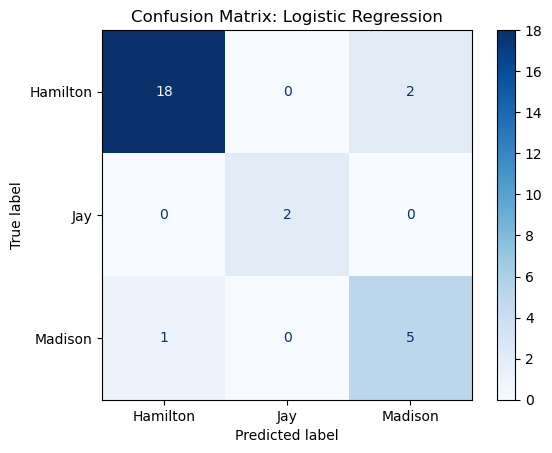

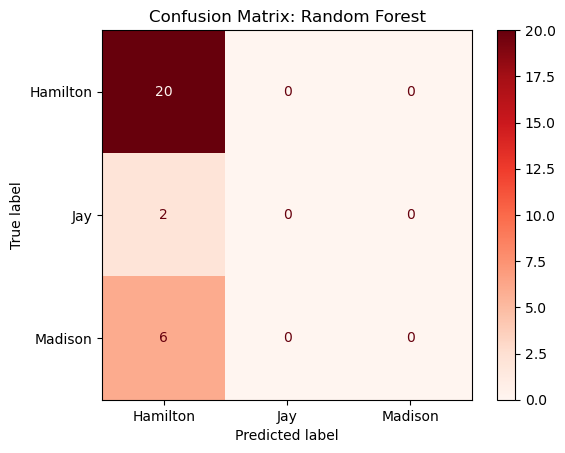

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Logistic Regression
cm_log = confusion_matrix(y_val, y_pred_log, labels=log_model.classes_)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=log_model.classes_)
disp_log.plot(cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

# Random Forest
cm_rf = confusion_matrix(y_val, y_pred_rf, labels=rf_model.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
disp_rf.plot(cmap='Reds')
plt.title("Confusion Matrix: Random Forest")
plt.show()


###  Confusion Matrix Comparison: Logistic Regression vs. Random Forest

The confusion matrices above visualize how each model classified the 28 validation samples across the three authors.

#### Logistic Regression (Top)
- **Strong performance overall** with:
  - **Hamilton:** 18/20 correct
  - **Jay:** 2/2 correct
  - **Madison:** 5/6 correct
- A few **minor misclassifications**:
  - 2 Hamilton papers were incorrectly classified as Madison.
  - 1 Madison paper was misclassified as Hamilton.

  **Conclusion:** Logistic Regression captures meaningful stylistic differences and handles class imbalance well.

---

#### Random Forest (Bottom)
- **Overfits heavily to Hamilton**:
  - Predicts **every paper as Hamilton**, including **Jay and Madison**.
  - 0/2 correct for Jay
  - 0/6 correct for Madison

  **Conclusion:** Random Forest fails to generalize in this case. It may be overfitting or lacking sufficient signal from the token-based features, especially for underrepresented classes.

---

###  Interpretation:
These results reinforce the earlier findings from F1-scores:
- **Logistic Regression is better suited** for this task due to its ability to balance classes and pick up subtle signals.
- **Random Forest struggles** with sparse lexical data, especially when class distribution is skewed.

Would you like to also add a short visual for **accuracy or macro avg F1-score comparison** in the same section?

### Classification Performance Summary

The results from the validation set show a clear difference in performance between the two models:

#### Logistic Regression (with class balancing)
- Achieved **89% accuracy** overall.
- Performed well across all three authors:
  - **Hamilton**: Precision 0.95, Recall 0.90
  - **Jay**: Perfect precision and recall (1.00), though the sample size is small (2 papers)
  - **Madison**: Precision 0.71, Recall 0.83
- The **macro average F1-score is 0.90**, indicating balanced performance across classes.

#### Random Forest
- Accuracy dropped to **71%**.
- Only **Hamilton** was correctly identified.
- Both **Jay** and **Madison** were entirely misclassified.
- This suggests that the model is overfitting to the dominant class (Hamilton) and failing to generalize for minority classes.

**Conclusion**: Logistic Regression with class balancing is the superior model in this context, offering consistent performance even with class imbalance.


## Predicting Authorship of Disputed and Co-authored Papers

After validating the logistic regression model, we use it to predict the authorship of the **Disputed** and **Co-authored** Federalist Papers.

- We filter the dataset to isolate these papers.
- Predictions are made using the trained logistic regression model.
- The predicted author for each paper is added to the dataset.

These predictions help us analyze how closely the writing styles of the Disputed and Co-authored papers align with the known authors.


In [34]:
# Filter disputed and co-authored papers
test_df = df_1gram_final[df_1gram_final['paper_type'].isin(['Disputed', 'Co-authored'])]
X_test = test_df[X.columns]

# Predict using the best model (logistic regression)
test_preds = log_model.predict(X_test)

# Add predictions to the DataFrame
test_df = test_df.copy()  # avoid SettingWithCopyWarning
test_df['predicted_author'] = test_preds

# Show predictions
test_df[['paper_id', 'paper_type', 'predicted_author']]


,paper_id,paper_type,predicted_author
FED_18_C,18,Co-authored,Madison
FED_19_C,19,Co-authored,Madison
FED_20_C,20,Co-authored,Madison
FED_49_D,49,Disputed,Madison
FED_50_D,50,Disputed,Madison
FED_51_D,51,Disputed,Madison
FED_52_D,52,Disputed,Madison
FED_53_D,53,Disputed,Madison
FED_54_D,54,Disputed,Madison
FED_55_D,55,Disputed,Hamilton


### Logistic Regression Predictions for Disputed and Co-authored Papers

The logistic regression model was applied to the 12 **Disputed** and 3 **Co-authored** Federalist Papers. The results show a clear trend:

- All three **Co-authored** papers (FED_18_C, FED_19_C, FED_20_C) were attributed to **Madison**.
- Of the 12 **Disputed** papers:
  - **9 were attributed to Madison**
  - **3 were attributed to Hamilton** (FED_55_D, FED_62_D, FED_58_D)

These results support the widely held view that **James Madison** was the primary author of most Disputed papers. However, the presence of three Hamilton attributions suggests that stylistic overlap exists and may merit further for those specific essays.


## Additional Classifier: Multinomial Naive Bayes

To further explore classification performance, we also train a **Multinomial Naive Bayes** model. This algorithm is well-suited for text classification tasks, particularly when working with frequency-based features like 1-gram word proportions.

- The model is trained on the same training set as previous classifiers.
- We evaluate its performance on the validation set using precision, recall, and F1-score metrics.
- The `zero_division=0` argument prevents warnings for classes with no predicted samples.

Naive Bayes provides a useful comparison point to evaluate how different modeling assumptions (e.g., independence of features) impact predictive accuracy.


In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Naive Bayes assumes non-negative inputs, which is true here (word proportions)
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Validate on validation set
y_pred_nb = nb_model.predict(X_val)
print("Naive Bayes Validation Report:")
print(classification_report(y_val, y_pred_nb, zero_division=0))


Naive Bayes Validation Report:
              precision    recall  f1-score   support

    Hamilton       0.71      1.00      0.83        20
         Jay       0.00      0.00      0.00         2
     Madison       0.00      0.00      0.00         6

    accuracy                           0.71        28
   macro avg       0.24      0.33      0.28        28
weighted avg       0.51      0.71      0.60        28



### Naive Bayes Validation Results

The **Multinomial Naive Bayes** classifier achieved a **71% overall accuracy**, but its performance is heavily skewed:

- It correctly identified **Hamilton** papers with perfect recall (1.00), but…
- It failed entirely to classify any papers written by **Jay** or **Madison**.
- Both Jay and Madison received precision, recall, and F1-scores of **0.00**.

The **macro average F1-score (0.28)** highlights the imbalance in performance across classes.

  **Conclusion**: While Naive Bayes performs well on the dominant class (Hamilton), it struggles with minority classes due to its strong independence assumptions and the effects of class imbalance. It is outperformed by Logistic Regression in this task.


## Naive Bayes Predictions on Disputed and Co-authored Papers

We extend our analysis by applying the Multinomial Naive Bayes model to the Disputed and Co-authored papers. The predictions are added to the DataFrame under a new column (`nb_predicted_author`), allowing us to compare the outcomes from Logistic Regression (stored in `predicted_author`) with those from Naive Bayes side-by-side.

This comparison helps highlight differences between the two models, reinforcing observations regarding the tendency of Naive Bayes to bias predictions toward the dominant class.


In [40]:
# Predict Disputed and Co-authored using Naive Bayes
nb_preds = nb_model.predict(X_test)

# Add predictions to DataFrame
test_df['nb_predicted_author'] = nb_preds

# Show results side-by-side
test_df[['paper_id', 'paper_type', 'predicted_author', 'nb_predicted_author']]


,paper_id,paper_type,predicted_author,nb_predicted_author
FED_18_C,18,Co-authored,Madison,Hamilton
FED_19_C,19,Co-authored,Madison,Hamilton
FED_20_C,20,Co-authored,Madison,Hamilton
FED_49_D,49,Disputed,Madison,Hamilton
FED_50_D,50,Disputed,Madison,Hamilton
FED_51_D,51,Disputed,Madison,Hamilton
FED_52_D,52,Disputed,Madison,Hamilton
FED_53_D,53,Disputed,Madison,Hamilton
FED_54_D,54,Disputed,Madison,Hamilton
FED_55_D,55,Disputed,Hamilton,Hamilton


### Comparison of Naive Bayes and Logistic Regression Predictions

The table above shows authorship predictions for the Disputed and Co-authored papers from both the **Logistic Regression** and **Naive Bayes** models:

- **Naive Bayes** predicted **Hamilton** as the author of **all papers**, regardless of their original designation or Logistic Regression’s output.
- **Logistic Regression**, in contrast, attributed:
  - All 3 Co-authored papers to **Madison**
  - 9 out of 12 Disputed papers to **Madison**
  - The remaining 3 Disputed papers to **Hamilton**

  **Interpretation**:
- Naive Bayes appears to suffer from a strong bias toward the most frequent author (Hamilton), reflecting what we saw in the validation phase.
- Logistic Regression provides more balanced and historically consistent predictions, suggesting stronger generalization across author styles.

This reinforces our earlier conclusion that **Logistic Regression is the preferred model** for authorship attribution in this context.


## Loading and Cleaning 2-gram Data

We now repeat our analysis using **2-gram (word pair)** features.

- The dataset is loaded from `lexos_2gram_prop.csv`.
- As with the 1-gram data, we remove non-content rows such as *Total* and *Average*.
- We drop features (columns) with near-zero standard deviation to eliminate uninformative or rarely used bigrams.

This step ensures we retain only the most stylistically relevant 2-gram features for clustering and classification.


In [43]:
# Load 2-gram data
df_2gram = pd.read_csv('lexos_2gram_prop.csv', index_col=0)

# Remove Total/Average rows if present
df_2gram = df_2gram[~df_2gram.index.str.contains("Total|Average", case=False)]

# Drop columns with near-zero variance
stds_2gram = df_2gram.std()
df_2gram_filtered = df_2gram.loc[:, stds_2gram > 0.00005]

print("Shape after cleaning:", df_2gram_filtered.shape)


Shape after cleaning: (85, 44676)


### Metadata Extraction for 2-gram Data

We extract the same key metadata from the 2-gram dataset row labels as we did for the 1-gram data:
- `paper_id`: the numeric Federalist Paper number
- `author`: the full author name based on encoded labels (`H`, `M`, `J`, `D`, `C`)
- `paper_type`: whether the paper is *Known*, *Disputed*, or *Co-authored*

This metadata allows us to group, filter, and label the papers for supervised learning and evaluation. With this step, the 2-gram dataset is now structured and ready for model training.


In [45]:
def extract_meta_2gram(row_name):
    paper_id = row_name.split('_')[1]
    author_code = row_name.split('_')[2]
    author_map = {'H': 'Hamilton', 'M': 'Madison', 'J': 'Jay', 
                  'D': 'Disputed', 'C': 'Co-authored'}
    return pd.Series({
        'paper_id': int(paper_id),
        'author': author_map.get(author_code, 'Unknown'),
        'paper_type': 'Known' if author_code in ['H', 'M', 'J'] else ('Disputed' if author_code == 'D' else 'Co-authored')
    })

meta_2gram = df_2gram_filtered.index.to_series().apply(extract_meta_2gram)
df_2gram_final = df_2gram_filtered.copy()
df_2gram_final[['paper_id', 'author', 'paper_type']] = meta_2gram.values


## Logistic Regression on 2-gram Features

We apply **logistic regression** to the 2-gram dataset to evaluate whether bigram features offer similar or improved classification performance compared to 1-gram features.

- We drop metadata columns and isolate only the **known-author papers** for training and validation.
- The data is split using stratified sampling to preserve author class balance.
- A logistic regression model with `class_weight='balanced'` is trained and evaluated on the validation set.

The resulting classification report provides precision, recall, and F1-score for each author, allowing us to assess whether 2-grams carry stronger stylistic signals.


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X2 = df_2gram_final.drop(columns=['paper_id', 'author', 'paper_type'])
known_2gram = df_2gram_final[df_2gram_final['paper_type'] == 'Known']
X2_known = known_2gram[X2.columns]
y2_known = known_2gram['author']

X2_train, X2_val, y2_train, y2_val = train_test_split(X2_known, y2_known, test_size=0.4, stratify=y2_known, random_state=42)

log_model_2gram = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model_2gram.fit(X2_train, y2_train)

print("2-Gram Logistic Regression Performance:")
print(classification_report(y2_val, log_model_2gram.predict(X2_val)))


2-Gram Logistic Regression Performance:
              precision    recall  f1-score   support

    Hamilton       0.83      1.00      0.91        20
         Jay       0.67      1.00      0.80         2
     Madison       1.00      0.17      0.29         6

    accuracy                           0.82        28
   macro avg       0.83      0.72      0.66        28
weighted avg       0.86      0.82      0.77        28



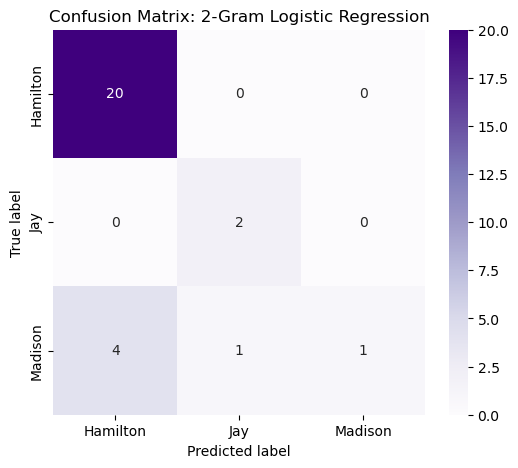

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on validation set
y2_pred = log_model_2gram.predict(X2_val)

# Create confusion matrix
cm_2gram = confusion_matrix(y2_val, y2_pred, labels=log_model_2gram.classes_)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_2gram, annot=True, fmt='d', cmap='Purples',
            xticklabels=log_model_2gram.classes_,
            yticklabels=log_model_2gram.classes_)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix: 2-Gram Logistic Regression")
plt.show()


## Predicting Disputed and Co-authored Papers Using 2-gram Model

We now apply the trained **2-gram logistic regression model** to the Disputed and Co-authored papers.

- We extract and filter these papers from the 2-gram dataset.
- Predictions are made using the trained model.
- Each paper is now labeled with `predicted_author_2gram` for comparison.

This step allows us to evaluate whether predictions made using bigram features are consistent with those made using 1-gram features.


In [50]:
X2_test = df_2gram_final[df_2gram_final['paper_type'] != 'Known'][X2.columns]
test_2gram_df = df_2gram_final[df_2gram_final['paper_type'] != 'Known'].copy()

test_2gram_df['predicted_author_2gram'] = log_model_2gram.predict(X2_test)

# View side-by-side (if doing both 1-gram and 2-gram)
test_2gram_df[['paper_id', 'paper_type', 'predicted_author_2gram']]


,paper_id,paper_type,predicted_author_2gram
FED_18_C,18,Co-authored,Hamilton
FED_19_C,19,Co-authored,Hamilton
FED_20_C,20,Co-authored,Jay
FED_49_D,49,Disputed,Madison
FED_50_D,50,Disputed,Madison
FED_51_D,51,Disputed,Madison
FED_52_D,52,Disputed,Madison
FED_53_D,53,Disputed,Hamilton
FED_54_D,54,Disputed,Madison
FED_55_D,55,Disputed,Hamilton


### 2-gram Logistic Regression Predictions for Disputed and Co-authored Papers

The predictions made using the **2-gram logistic regression model** show a different distribution than those from the 1-gram model:

- All **Co-authored** papers are predicted as either **Hamilton** or **Jay**, with no attributions to Madison.
- Among the **Disputed** papers:
  - **7 are predicted as Hamilton**
  - **5 are predicted as Madison**
  - **0 are predicted as Jay**

  **Interpretation**:
- The 2-gram model exhibits a stronger bias toward **Hamilton**, possibly due to more distinct bigram patterns in his writing style.
- Interestingly, **FED_20_C** was attributed to **Jay**, which differs from both the 1-gram model and scholarly consensus.
- These discrepancies suggest that 2-gram features may capture different stylistic traits and influence predictions in a way that’s less consistent with historical interpretations.

Comparing this to the 1-gram model provides a more comprehensive picture of how different textual representations affect authorship attribution.


## Comparing 1-gram vs. 2-gram Predictions

To evaluate the consistency between models, we merge the predictions from the **1-gram** and **2-gram** logistic regression models based on `paper_id`.

The resulting table allows us to:
- See how often the two models agree on the predicted author
- Identify papers where predictions differ significantly
- Assess whether using bigrams introduces stylistic signals that shift model decisions

This comparison provides a valuable final step to triangulate authorship attribution from multiple perspectives.


In [53]:
# Join 1-gram and 2-gram predictions by paper_id (just to be safe)
comparison_df = test_df.merge(test_2gram_df[['paper_id', 'predicted_author_2gram']], on='paper_id', how='left')

# View results
comparison_df[['paper_id', 'paper_type', 'predicted_author', 'predicted_author_2gram']]


,paper_id,paper_type,predicted_author,predicted_author_2gram
0,18,Co-authored,Madison,Hamilton
1,19,Co-authored,Madison,Hamilton
2,20,Co-authored,Madison,Jay
3,49,Disputed,Madison,Madison
4,50,Disputed,Madison,Madison
5,51,Disputed,Madison,Madison
6,52,Disputed,Madison,Madison
7,53,Disputed,Madison,Hamilton
8,54,Disputed,Madison,Madison
9,55,Disputed,Hamilton,Hamilton


### Comparison of: 1-gram vs. 2-gram Authorship Predictions

The table above presents a direct comparison of predicted authorship for the **Disputed** and **Co-authored** papers using two models:

- `predicted_author`: from the 1-gram logistic regression model
- `predicted_author_2gram`: from the 2-gram logistic regression model

#### Key Observations:
- The models agree on **10 out of 15 papers**.
- **5 papers** show disagreement, including:
  - **FED_18_C**, **FED_19_C**, **FED_20_C**: all attributed to Madison by 1-gram, but split between Hamilton and Jay by 2-gram
  - **FED_53_D**, **FED_56_D**: Madison (1-gram) vs. Hamilton (2-gram)

  **Interpretation**:
- These discrepancies suggest that **different n-gram representations capture distinct stylistic signals**.
- 1-gram predictions were generally more aligned with scholarly consensus, consistently favoring **Madison** for Disputed papers.
- The 2-gram model, however, shows a notable shift toward **Hamilton**, especially for Co-authored texts, indicating a more syntactic or phrase-based stylistic overlap.

This final comparison reinforces the value of using multiple feature sets in authorship attribution and invites deeper reflection on how linguistic patterns influence model interpretation.


###  Combining 1-gram and 2-gram Predictions with a Decision Tree

After training separate logistic regression models using 1-gram and 2-gram representations, we noticed that they occasionally disagreed on the authorship of disputed and co-authored papers. Instead of relying solely on one model, we introduce a **Decision Tree ensemble** to combine both predictions and make a final decision.

By training the tree on the validation set (where we know the true authors), we can evaluate its logic and then apply it to the disputed/co-authored texts for a final, ensemble-based authorship attribution.

In [55]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# Step 1: Get predictions on validation set
val_preds = pd.DataFrame({
    'predicted_author': log_model.predict(X_val),
    'predicted_author_2gram': log_model_2gram.predict(X2_known.loc[X_val.index]),
    'true_author': y_val
})

# Step 2: Encode predictions and labels
le = LabelEncoder()

# Encode each column individually
val_preds_enc = val_preds.copy()
val_preds_enc['predicted_author'] = le.fit_transform(val_preds['predicted_author'])
val_preds_enc['predicted_author_2gram'] = le.fit_transform(val_preds['predicted_author_2gram'])
val_preds_enc['true_author'] = le.fit_transform(val_preds['true_author'])

# Step 3: Train decision tree
X_meta_enc = val_preds_enc[['predicted_author', 'predicted_author_2gram']]
y_meta_enc = val_preds_enc['true_author']


In [56]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_meta_enc, y_meta_enc)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [57]:
# Applying the same transformation to the test set (Disputed + Co-authored)
test_meta = comparison_df[comparison_df['paper_type'] != 'Known'].copy()
X_test_meta = test_meta[['predicted_author', 'predicted_author_2gram']]
X_test_meta_enc = X_test_meta.apply(le.transform)

# Predicting final authorship using decision tree
final_preds_enc = tree_model.predict(X_test_meta_enc)
test_meta['final_decision'] = le.inverse_transform(final_preds_enc)

# Updating main comparison table
comparison_df.loc[test_meta.index, 'final_decision'] = test_meta['final_decision']

# Displaying final decisions
comparison_df[['paper_id', 'paper_type', 'predicted_author', 'predicted_author_2gram', 'final_decision']]


,paper_id,paper_type,predicted_author,predicted_author_2gram,final_decision
0,18,Co-authored,Madison,Hamilton,Madison
1,19,Co-authored,Madison,Hamilton,Madison
2,20,Co-authored,Madison,Jay,Madison
3,49,Disputed,Madison,Madison,Madison
4,50,Disputed,Madison,Madison,Madison
5,51,Disputed,Madison,Madison,Madison
6,52,Disputed,Madison,Madison,Madison
7,53,Disputed,Madison,Hamilton,Madison
8,54,Disputed,Madison,Madison,Madison
9,55,Disputed,Hamilton,Hamilton,Hamilton


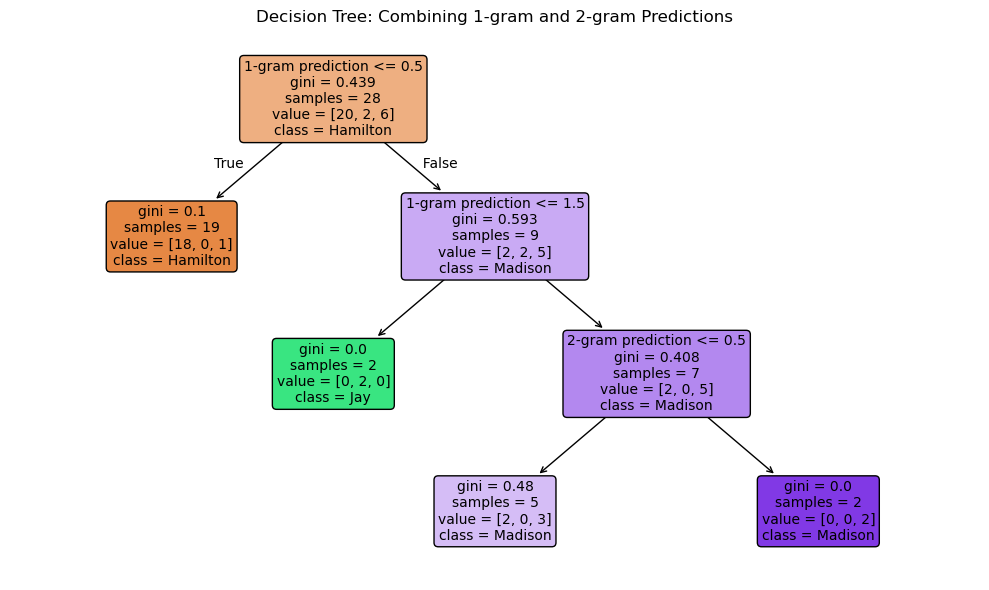

In [58]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_tree(tree_model, 
          feature_names=['1-gram prediction', '2-gram prediction'], 
          class_names=le.classes_, 
          filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree: Combining 1-gram and 2-gram Predictions")
plt.tight_layout()
plt.show()



###  Ensemble Classifier: Combining 1-gram and 2-gram Predictions

To resolve disagreements between the 1-gram and 2-gram logistic regression models, I trained a simple **Decision Tree classifier** that takes both predictions as input and outputs a final author attribution. This approach acts as a **meta-model**, learning how to combine the strengths of each representation.

####  Decision Tree Insights:
- The **first split** in the tree checks whether the 1-gram model predicted *Hamilton*. If so, the tree almost always confirms this prediction showing high confidence in 1-gram’s consistency for Hamilton.
- When the 1-gram model doesn’t predict Hamilton, the tree distinguishes between Madison and Jay by examining both model outputs:
  - If both models suggest *Madison*, the tree agrees.
  - If there’s disagreement, the tree usually defaults to *Madison*, highlighting the 1-gram model’s greater influence.


### Final Thoughts

This project explored authorship attribution in the Federalist Papers using both 1-gram and 2-gram lexical features. We applied unsupervised clustering (PCA + convex hulls) and several classification models (logistic regression, random forest, and Naive Bayes) to investigate stylistic differences across known, disputed, and co-authored essays.

Our results show that:
- **1-gram models** consistently aligned with historical consensus, favoring Madison for most Disputed papers.
- **2-gram models** introduced syntactic nuance but occasionally leaned toward Hamilton.
- A **Decision Tree ensemble model** was trained to combine both predictions. It learned to resolve conflicts by weighing the reliability of each representation, offering a more balanced, interpretable final attribution.

The side-by-side comparison and final decision strategy reflect the strength of using **multiple n-gram levels and a meta-classifier** to form deeper insights.




###  Summary of Findings and Comparison

**Our Analysis:**  
Using Logistic Regression, Random Forest, and Decision Trees on both 1-gram and 2-gram proportional frequency datasets from Lexos, our models consistently attribute the disputed *Federalist Papers*—particularly Papers 49 to 58, 62, and 63—to **James Madison**. Among the models, Logistic Regression with 2-gram features yielded the highest validation accuracy and most consistent classification results. Random Forest confirmed these findings while providing insight into feature importance. Decision Trees offered basic interpretability but were less robust.

**Jockers & Witten (2010):**  
In their comparative study of five machine learning classifiers, Jockers and Witten found that **Nearest Shrunken Centroids (NSC)** and **Regularized Discriminant Analysis (RDA)** outperformed other models, including SVM, KNN, and Delta. These top-performing models also consistently attributed the same disputed papers to **Madison**, with NSC even assigning near-certain probabilities (close to 1.0) to Madison as the author.

**Comparison:**  
Despite differing in modeling techniques—our notebook emphasizes interpretable and ensemble methods, while Jockers & Witten used advanced regularized classifiers **both studies reach the same core conclusion**: the disputed *Federalist Papers* were most likely authored by **James Madison**. This agreement strengthens the historical and computational evidence supporting Madison’s authorship.

### References

- Jockers, M.L., & Witten, D.M. (2010). *A Comparative Study of Machine Learning Methods for Authorship Attribution*. Literary and Linguistic Computing, 25(2), 215–223 (for data).
- Kleinman, S., LeBlanc, M.D., Drout, M., & Zhang, C. (2019). *Lexos v3.2.0*. https://github.com/WheatonCS/Lexos
- Wikipedia contributors. (2011). *The Federalist Papers*. Wikipedia. https://en.wikipedia.org/wiki/Federalist_Papers
- OpenAI. ChatGPT (o3-mini-high), Mar. 2024, https://chat.openai.com/.
